# "Zillow Zingzestimate Project"

## Background

*Zillow is an online real estate database company founded in 2006 - Wikipedia.* “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today). The Zillow Zestimate Zing Project will predict the error between Zestimate and the sales price of a home. 

- Project By `Ednalyn C. De Dios`
- Codeup Data Science
- ADA Cohort
- 25 March 2019

## Project Planning

### Goals

- Determine variables that drive log errors.
- Develop a linear regression model that will best predict the log errors.

### Deliverables

1. Report
1. Jupyter Notebook

### Data Dictionary & Details


***We will be using 2016 data.***

- logerror: log function of the error between Zestimate and sale price of a home.
- bathroomcnt:  Number of bathrooms in home including fractional bathrooms.
- bedroomcnt:  Number of bedrooms in home.
- calculatedfinishedsquarefeet:  Calculated total finished living area of the home.
- fullbathcnt:  Number of full bathrooms (sink, shower + bathtub, and toilet) present in home.
- garagecarcnt:  Total number of garages on the lot including an attached garage.
- roomcnt:  Total number of rooms in the principal residence.
- yearbuilt:  The Year the principal residence was built.
- taxvalueddollarcnt: The total tax assessed value of the parcel.
- taxamount: The total property tax assessed for that assessment year.

### Initial Thoughts, Ideas, Hypotheses

1. Location, location, location! Does location affect the log error?
1. To what extent does size matter?
1. How much do the number of bedroom and bathrooms play a role in driving the log error?
1. Depending on geography, do heating and air conditioning play a role?
1. What other variables drives the log error?


### Preparing the Environment

Libraries imported below for data wrangling, exploring, visualizing, and modeling will be used throughout the project.

In [1]:
# Wrangling
import pandas as pd
import math
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

from env import user, host, password, path

#### Utilities
*TODO: Functions to export in the `util.py` later.*

In [2]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

def validate_tts(X_train, y_train, X_test, y_test):
    if X_train.shape[0] == y_train.shape[0]:
        print("X & y train rows ARE equal")
    else:
        print("X & y train rows ARE NOT equal")


    if X_test.shape[0] == y_test.shape[0]:
        print("X & y test rows ARE equal")
    else:
        print("X & y test rows ARE NOT equal")

    if train.shape[1] == test.shape[1]:
        print("Number of columns in train & test ARE equal")
    else:
        print("Number of columns in train & test ARE NOT equal")

    train_split = train.shape[0] / (train.shape[0] + test.shape[0])
    test_split = test.shape[0] / (train.shape[0] + test.shape[0])

    print("Train Split: %.2f" % train_split)
    print("Test Split: %.2f" % test_split)

### Data Acquisition

- Acquire the data via csv files.
- Generate cohesive dataset with recommended columns.


In [3]:
# Acquire the data via csv
train_df = pd.read_csv(path+"train_2016_v2.csv", low_memory=False)
properties_df = pd.read_csv(path+"properties_2016.csv", low_memory=False)

# Generate a cohesive dataset
df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
df = df[['logerror',
         'bathroomcnt',
         'bedroomcnt',
         'calculatedfinishedsquarefeet',
         'fullbathcnt',
         'garagecarcnt',
         'roomcnt',
         'yearbuilt',
         'taxvaluedollarcnt',
         'taxamount']]

Log errors were filtered organically after merging.

In [4]:
# Check for null values in the columns
print(df.isnull().sum())

# Check number of rows and columns after merging
print(df.shape)

logerror                            0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
roomcnt                             0
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
dtype: int64
(90275, 10)


#### Discard unwanted columns.

In [5]:
# Remove these columns entirely due to high number of null and zero values
df = df.drop(['garagecarcnt', 'roomcnt'], axis=1)
print(df.sample(10))

       logerror  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
10181   -0.0440          2.0         3.0                        1273.0   
83452    0.0325          2.0         2.0                         985.0   
16082    0.0383          3.5         4.0                        4169.0   
55161    0.0488          3.0         3.0                        1710.0   
19167    0.0535          3.0         4.0                        2032.0   
83539    0.0402          1.0         3.0                        1224.0   
12067   -0.0398          2.0         3.0                        1603.0   
32807   -1.0730          1.0         2.0                         810.0   
13244    0.0695          2.0         3.0                        1467.0   
81372    0.0218          3.0         5.0                        2795.0   

       fullbathcnt  yearbuilt  taxvaluedollarcnt  taxamount  
10181          2.0     1971.0           240900.0    2634.44  
83452          2.0     1989.0           320100.0    4205.04  

Summarize the data using predefined function.

In [6]:
# General dataset
summarize_df(df)

Summary of Data

Rows & Columns:

(90275, 8)
Variables:

['logerror' 'bathroomcnt' 'bedroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'yearbuilt' 'taxvaluedollarcnt' 'taxamount']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
dtypes: float64(8)
memory usage: 6.2 MB
None

Numeric Summary Stats:

           logerror   bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet  \
count  90275.000000  90275.000000  90275.000000                  89614.000000   
mean       0.01145

### Data Preparation

Our goal is to leave this section with a dataset that is ready to be analyzed. 

In [7]:
# Discard rows where respective column contains null
df = df[df['calculatedfinishedsquarefeet'].notnull()]
df = df[df['fullbathcnt'].notnull()]
df = df[df['yearbuilt'].notnull()]
df = df[df['taxvaluedollarcnt'].notnull()]
df = df[df['taxamount'].notnull()]

# Check for null values
print(df.isnull().sum())
df.sample(10)

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
84974,-0.0202,2.0,3.0,1152.0,2.0,1955.0,249820.0,3175.84
3981,-0.0090,2.0,3.0,2136.0,2.0,1955.0,460936.0,5506.72
85201,0.0109,3.0,2.0,1403.0,3.0,1984.0,570310.0,7020.65
55842,0.0060,2.0,2.0,1094.0,2.0,1953.0,71101.0,1192.25
13070,0.0573,1.0,2.0,809.0,1.0,1973.0,238000.0,3089.68
5959,-0.0070,2.5,4.0,1970.0,2.0,1989.0,642587.0,6740.76
54547,-0.0131,2.0,4.0,1612.0,2.0,1964.0,365783.0,4644.38
67969,-0.0429,1.0,1.0,358.0,1.0,1979.0,79885.0,1032.10
87704,-0.0060,2.0,4.0,2738.0,2.0,1961.0,805525.0,8653.40
32779,0.0080,1.0,2.0,1050.0,1.0,1946.0,125603.0,1911.21


#### Create a variable, `colnames`, that is a list of the column names. 
We will likely reference this variable later.

In [8]:
colnames = ['logerror',
            'bathroomcnt',
            'bedroomcnt',
            'calculatedfinishedsquarefeet',
            'fullbathcnt',
            'yearbuilt',
            'taxvaluedollarcnt',
            'taxamount'
           ]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
76175,0.0227,2.0,3.0,1349.0,2.0,1939.0,650000.0,7094.17
12693,0.0159,1.0,1.0,620.0,1.0,1972.0,221000.0,2737.26
8,-0.0030,1.0,2.0,796.0,1.0,1984.0,210064.0,2172.88
15728,-0.0790,5.0,4.0,4507.0,5.0,1958.0,4134591.0,48922.17
39869,-0.1043,3.0,2.0,1618.0,3.0,2003.0,1150000.0,14033.44
68806,0.0010,2.5,3.0,1653.0,2.0,2000.0,647000.0,7826.42
76216,-0.0212,3.0,4.0,2876.0,3.0,1996.0,437012.0,4796.54
48735,0.0573,1.0,2.0,1280.0,1.0,1937.0,391912.0,4863.89
22481,0.0431,3.0,4.0,2912.0,3.0,1979.0,336612.0,3606.68
35201,-0.0070,3.0,4.0,1457.0,3.0,1948.0,249700.0,3169.89


#### Identify the data types of each variable. Why? 
We need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null float64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(8)
memory usage: 6.1 MB
None


We still need to convert yearbuilt to integer and remove the trailing .0 as well.

In [10]:
# Convert from years to integer
df['yearbuilt'] = df['yearbuilt'].astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
yearbuilt                       88998 non-null int64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(7), int64(1)
memory usage: 6.1 MB
None


In [11]:
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
61687,0.0266,2.0,2.0,1085.0,2.0,1986,291000.0,3769.09
71227,-0.0987,2.0,4.0,1405.0,2.0,1947,62581.0,1078.45
47279,0.0060,2.0,5.0,2165.0,2.0,1964,662796.0,7504.76
30859,0.0440,2.0,3.0,994.0,2.0,1954,470000.0,5772.43
61307,0.0119,1.5,1.0,817.0,1.0,1983,190735.0,1995.60
46987,-0.0090,1.0,2.0,851.0,1.0,1947,215098.0,2640.07
87524,0.1898,4.0,5.0,3424.0,4.0,2001,1446501.0,16703.79
34958,0.0344,2.5,2.0,1176.0,2.0,1985,192476.0,2138.58
74258,0.0169,1.0,1.0,853.0,1.0,1977,82913.0,1005.78
34856,0.0276,3.0,3.0,1318.0,3.0,1976,335573.0,4365.22


#### Identify the columns that have missing values and the number of missing values in each column. 
Missing values are going to cause issues down the line so we will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if we should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [12]:
# Check for null values
df.isnull().sum()

logerror                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
dtype: int64

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
During exploration, we will likely use this list to refer to the attribute names.

In [13]:
x_vars = ['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]

#### We need to clearly identify our dependent (target) variable. 
- `logerror` is our target variable, a continuous variable.

In [14]:
# Take the absolute value of log errors
df.logerror = df.logerror.abs()
df.logerror.sample(10)

70115    0.0151
35046    0.0715
2159     0.0222
64785    0.2206
65093    0.0257
30525    1.2070
43503    0.1832
41794    0.0677
48448    0.0534
78517    0.0686
Name: logerror, dtype: float64

#### View the distribution of the numeric variables
- We will plot a histogram and box plot of each variable to see the distribution, skewness, outliers, and unit scales. We will use this information in our decision of whether to normalize, standardize or neither.

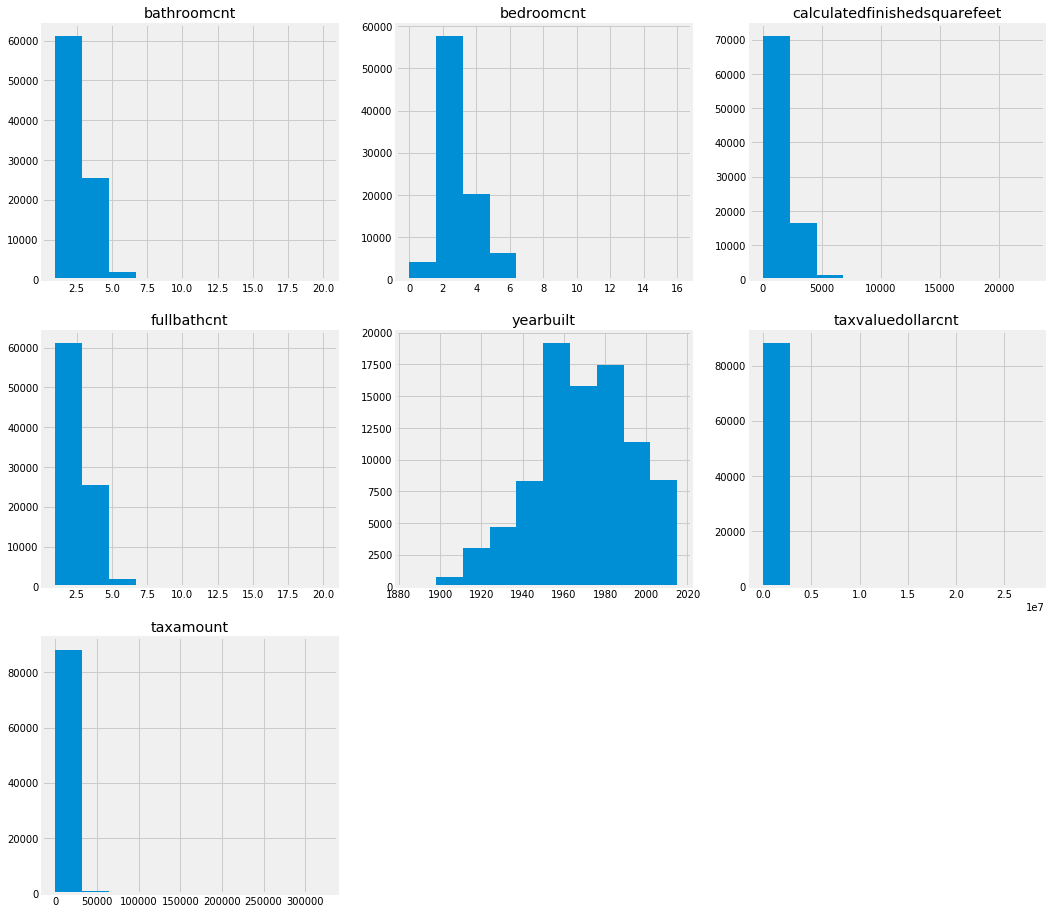

In [15]:
# Histogram
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3,3,plot_number)
    plt.title(col)
    series.hist()

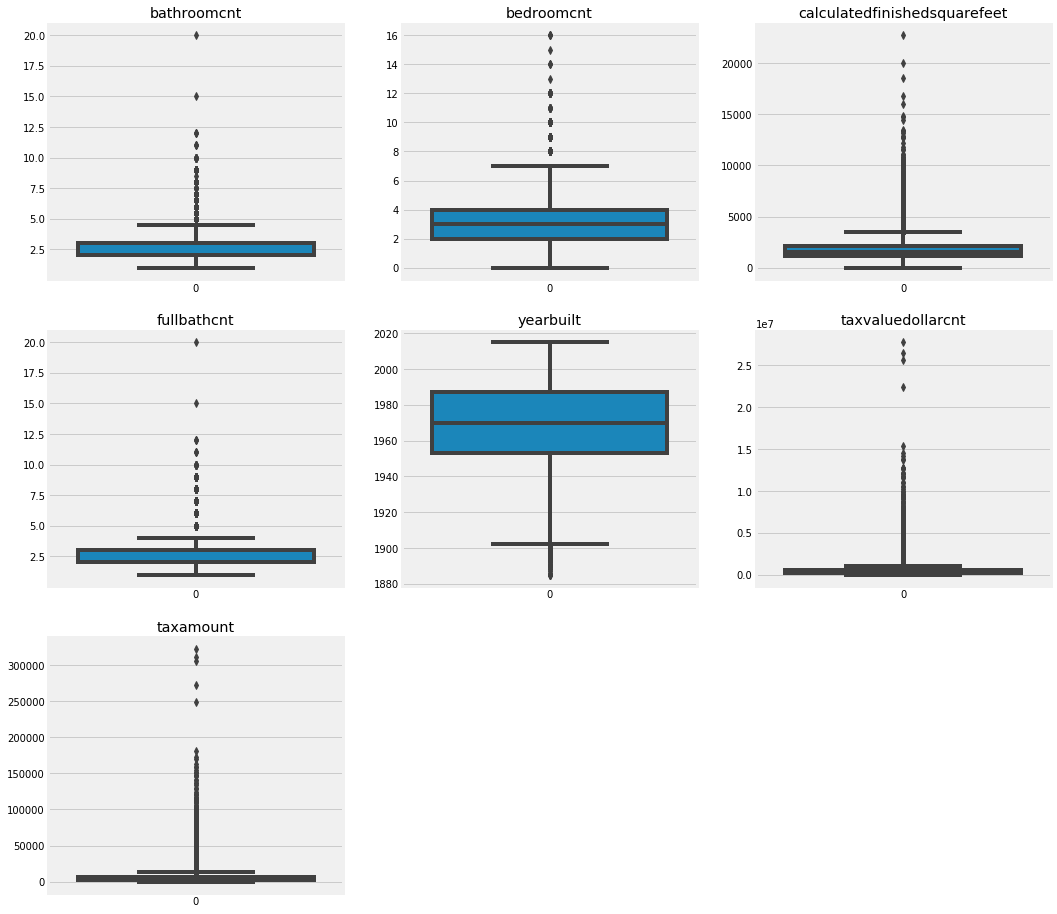

In [16]:
# Box plot
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    plt.subplot(3,3,plot_number)
    plt.title(col)
    sns.boxplot(data=df[col])

#### Discard unwated rows (observations).

In [17]:
# Remove outliers or nonsensical observations
df = df[df.bathroomcnt <= 12.5]
df = df[df.calculatedfinishedsquarefeet <= 17500]
df = df[df.fullbathcnt <= 12.5]
df = df[df.taxvaluedollarcnt <= 20000000.0]
df = df[df.taxamount <= 200000]
df.sample(10)

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
29646,0.0237,2.0,3.0,1364.0,2.0,1974,107957.0,1594.34
51670,0.1020,2.5,3.0,1850.0,2.0,2004,971130.0,13023.86
63707,0.0899,4.0,4.0,3103.0,4.0,1965,283643.0,4137.75
17323,0.0315,2.0,4.0,1376.0,2.0,1954,74394.0,1281.49
15454,0.0010,2.0,3.0,1740.0,2.0,1980,618000.0,7498.54
39231,0.0683,2.0,4.0,1411.0,2.0,1912,258138.0,3588.92
1111,0.2859,2.0,2.0,968.0,2.0,1982,220000.0,2627.73
75815,0.1132,3.0,5.0,2825.0,3.0,1999,665996.0,7333.68
56410,0.0010,2.0,2.0,814.0,2.0,1990,220291.0,2852.88
80977,0.1467,2.0,4.0,1632.0,2.0,1969,144874.0,1814.68


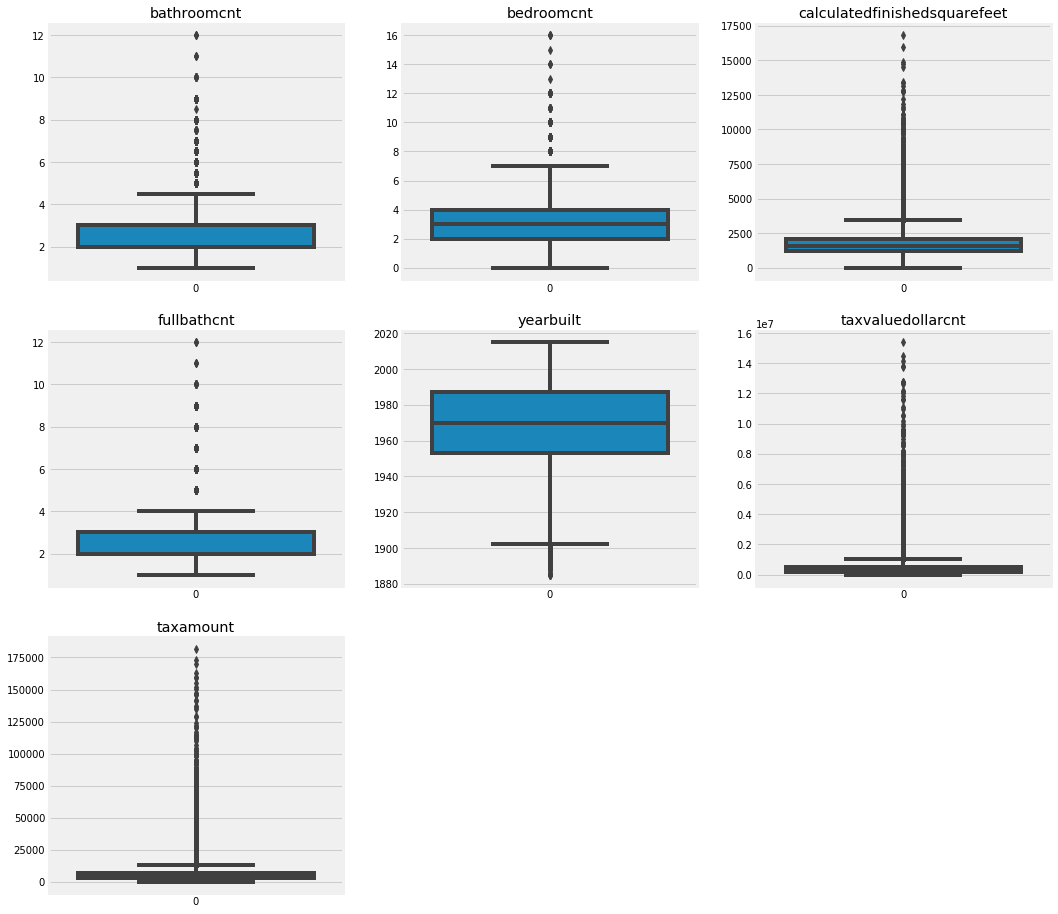

In [18]:
# Box plot
plt.figure(figsize=(16,16))
for i, col in enumerate(['bathroomcnt',
          'bedroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    plt.subplot(3,3,plot_number)
    plt.title(col)
    sns.boxplot(data=df[col])

Save the snippet below for the min max normalization later.

In [19]:
# std_df = df.drop(colnames, axis=1)

# std_df['log_error'] = df.logerror

# #std_df['bathroom_count'] = (df.bathroomcnt - df.bathroomcnt.min()) / (df.bathroomcnt.max() - df.bathroomcnt.min())
# std_df['bathroom_count'] = df.bathroomcnt
# #std_df['bathroom_count'] = (df.bedroomcnt - df.bedroomcnt.min()) / (df.bedroomcnt.max() - df.bedroomcnt.min())
# std_df['bedroom_count'] = df.bedroomcnt
# #std_df['square_feet'] = (df.calculatedfinishedsquarefeet - df.calculatedfinishedsquarefeet.min()) / (df.calculatedfinishedsquarefeet.max() - df.calculatedfinishedsquarefeet.min())
# std_df['square_feet'] = df.calculatedfinishedsquarefeet
# #std_df['full_bath_count'] = (df.fullbathcnt - df.fullbathcnt.min()) / (df.fullbathcnt.max() - df.fullbathcnt.min())
# std_df['full_bath_count'] = df.fullbathcnt
# #std_df['year_built'] = (df.yearbuilt - df.yearbuilt.min()) / (df.yearbuilt.max() - df.yearbuilt.min())
# std_df['year_built'] = df.yearbuilt
# #std_df['tax_value_count'] = (df.taxvaluedollarcnt - df.taxvaluedollarcnt.min()) / (df.taxvaluedollarcnt.max() - df.taxvaluedollarcnt.min())
# std_df['tax_value_count'] = df.taxvaluedollarcnt
# #std_df['tax_amount'] = (df.taxamount - df.taxamount.min()) / (df.taxamount.max() - df.taxamount.min())
# std_df['tax_amount'] = df.taxamount



In [20]:
# Just to be sure...
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88990 entries, 0 to 90274
Data columns (total 8 columns):
logerror                        88990 non-null float64
bathroomcnt                     88990 non-null float64
bedroomcnt                      88990 non-null float64
calculatedfinishedsquarefeet    88990 non-null float64
fullbathcnt                     88990 non-null float64
yearbuilt                       88990 non-null int64
taxvaluedollarcnt               88990 non-null float64
taxamount                       88990 non-null float64
dtypes: float64(7), int64(1)
memory usage: 8.6 MB


,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
15812,0.0910,1.5,2.0,1530.0,1.0,1967,1685481.0,19272.52
76852,0.0797,3.0,4.0,1538.0,3.0,1964,336000.0,4186.87
28466,0.0101,2.0,2.0,860.0,2.0,1989,338318.0,3709.24
58541,0.0344,1.0,2.0,1194.0,1.0,1928,266746.0,3297.06
86783,0.0100,6.0,5.0,4221.0,6.0,2012,2784443.0,31279.09
56138,0.0080,2.0,3.0,1162.0,2.0,1952,538000.0,6721.76
82697,0.0257,1.0,3.0,1071.0,1.0,1951,62773.0,4669.76
58634,0.0770,2.0,3.0,1533.0,2.0,1948,231953.0,3083.49
59031,0.0602,2.5,3.0,1901.0,2.0,1989,263042.0,2797.18
65064,0.0109,2.0,3.0,1421.0,2.0,1946,211758.0,2940.08


### Data Exploration

Our goal is to address each of the questions we posed in our planning & brainstorming through visual or statistical analysis.

When we complete this step, we will have the findings from our analysis that will be used in our final report, the answers to our questions and our customer's questions that will reach the goal. 

*The idea and code below were inspired and adapted from Sudalai Raj Kumar (SRK) at https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize .*

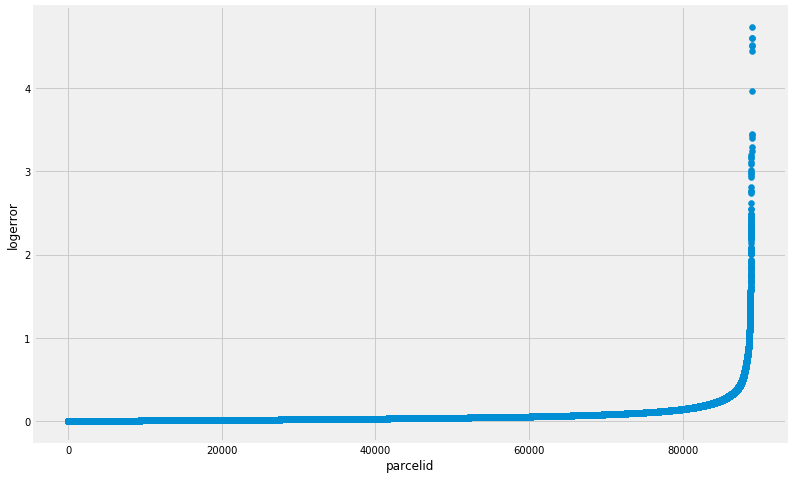

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


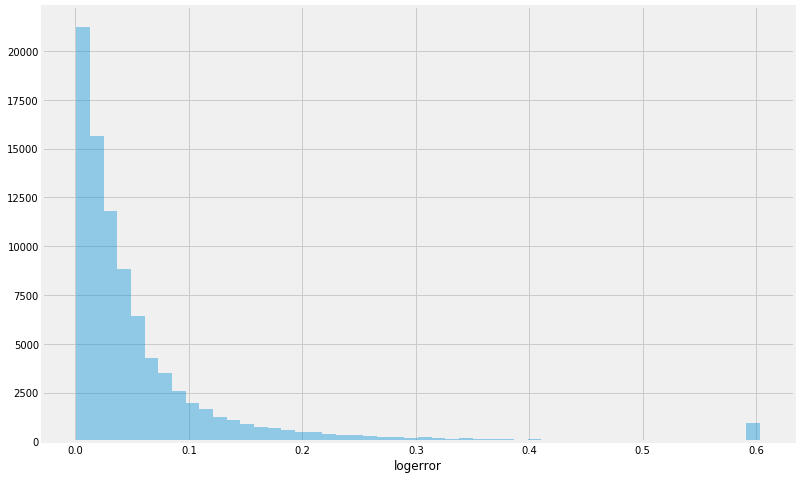

In [21]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(df.shape[0]), np.sort(df.logerror.values))
plt.xlabel('parcelid')
plt.ylabel('logerror')
plt.show()

# Remove outliers
ulimit = np.percentile(df.logerror.values, 99)
llimit = np.percentile(df.logerror.values, 1)
df['logerror'].loc[df['logerror']>ulimit] = ulimit
df['logerror'].loc[df['logerror']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

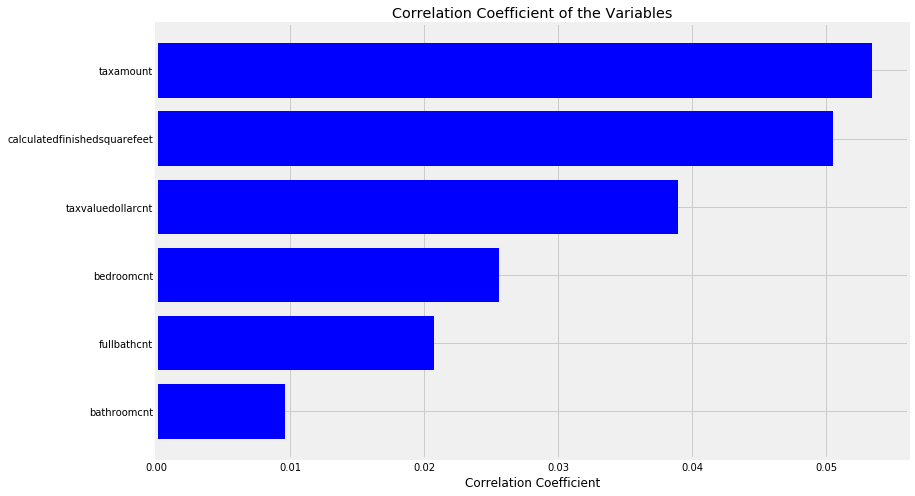

In [22]:
# Correlation coefficient of each of these variables
x_vars = [col for col in df.columns if col not in ['logerror'] if df[col].dtype=='float64']

labels = []
values = []
for col in x_vars:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.logerror.values)[0,1])
correlation_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
correlation_df = correlation_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 1
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(correlation_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(correlation_df.col_labels.values)
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficient of the Variables")
plt.show()

#### Split data into training and test datasets

In [23]:
# train_test_split
X = df.drop(['logerror'], axis=1)

print(X.head())

y = df[['logerror']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

validate_tts(X_train, y_train, X_test, y_test)

X.sample(10)

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.0         3.0                        1684.0          2.0   
1          3.5         4.0                        2263.0          3.0   
2          3.0         2.0                        2217.0          3.0   
3          2.0         2.0                         839.0          2.0   
4          2.5         4.0                        2283.0          2.0   

   yearbuilt  taxvaluedollarcnt  taxamount  
0       1959           360170.0    6735.88  
1       2014           585529.0   10153.02  
2       1940           119906.0   11484.48  
3       1987           244880.0    3048.74  
4       1981           434551.0    5488.96  
   logerror
0    0.0276
1    0.1684
2    0.0040
3    0.0218
4    0.0050

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']
Train dimensions (rows, columns): (71192, 8)

Test columns:  ['bat

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
37893,3.0,2.0,1416.0,3.0,1974,422460.0,4728.01
2446,2.0,2.0,1840.0,2.0,1955,397137.0,4748.09
43628,1.0,0.0,790.0,1.0,2006,319799.0,4029.49
52302,4.5,5.0,3181.0,4.0,2006,828000.0,9220.96
56853,3.0,3.0,1723.0,3.0,1984,203793.0,2695.29
33348,1.0,3.0,1303.0,1.0,1947,49732.0,1223.88
11239,1.0,2.0,816.0,1.0,1950,245208.0,3199.96
56885,3.0,4.0,2539.0,3.0,1939,127248.0,1843.28
12663,1.0,2.0,838.0,1.0,1950,357256.0,4371.08
15580,2.0,4.0,1623.0,2.0,1963,406540.0,4365.44


#### MIN-MAX NORMALIZATION

In [24]:
std_y_train = y_train.drop('logerror', axis=1)
std_y_train['log_error'] = y_train.logerror

std_X_train = X_train.drop(x_vars, axis=1)
std_X_train['bathroom_count'] = (X_train.bathroomcnt - X_train.bathroomcnt.min()) / (X_train.bathroomcnt.max() - X_train.bathroomcnt.min())
std_X_train['bedroom_count'] = (X_train.bedroomcnt - X_train.bedroomcnt.min()) / (X_train.bedroomcnt.max() - X_train.bedroomcnt.min())
std_X_train['square_feet'] = (X_train.calculatedfinishedsquarefeet - X_train.calculatedfinishedsquarefeet.min()) / (X_train.calculatedfinishedsquarefeet.max() - X_train.calculatedfinishedsquarefeet.min())
std_X_train['full_bath_count'] = (X_train.fullbathcnt - X_train.fullbathcnt.min()) / (X_train.fullbathcnt.max() - X_train.fullbathcnt.min())
std_X_train['year_built'] = (X_train.yearbuilt - X_train.yearbuilt.min()) / (X_train.yearbuilt.max() - X_train.yearbuilt.min())
std_X_train['tax_value_count'] = (X_train.taxvaluedollarcnt - X_train.taxvaluedollarcnt.min()) / (X_train.taxvaluedollarcnt.max() - X_train.taxvaluedollarcnt.min())
std_X_train['tax_amount'] = (X_train.taxamount - X_train.taxamount.min()) / (X_train.taxamount.max() - X_train.taxamount.min())

std_y_test = y_test.drop('logerror', axis=1)
std_y_test['log_error'] = y_test.logerror

std_X_test = X_test.drop(x_vars, axis=1)
std_X_test['bathroom_count'] = (X_test.bathroomcnt - X_train.bathroomcnt.min()) / (X_train.bathroomcnt.max() - X_train.bathroomcnt.min())
std_X_test['bedroom_count'] = (X_test.bedroomcnt - X_train.bedroomcnt.min()) / (X_train.bedroomcnt.max() - X_train.bedroomcnt.min())
std_X_test['square_feet'] = (X_test.calculatedfinishedsquarefeet - X_train.calculatedfinishedsquarefeet.min()) / (X_train.calculatedfinishedsquarefeet.max() - X_train.calculatedfinishedsquarefeet.min())
std_X_test['full_bath_count'] = (X_test.fullbathcnt - X_train.fullbathcnt.min()) / (X_train.fullbathcnt.max() - X_train.fullbathcnt.min())
std_X_test['year_built'] = (X_test.yearbuilt - X_train.yearbuilt.min()) / (X_train.yearbuilt.max() - X_train.yearbuilt.min())
std_X_test['tax_value_count'] = (X_test.taxvaluedollarcnt - X_train.taxvaluedollarcnt.min()) / (X_train.taxvaluedollarcnt.max() - X_train.taxvaluedollarcnt.min())
std_X_test['tax_amount'] = (X_test.taxamount - X_train.taxamount.min()) / (X_train.taxamount.max() - X_train.taxamount.min())


In [25]:
std_train = pd.concat([std_X_train, std_y_train], axis=1)

print()
print("std_train columns:  %s" % list(std_train.columns))
print("std_train dimensions (rows, columns):", std_train.shape)
print()

std_test = pd.concat([std_X_test, std_y_test], axis=1)

print("std_test columns:  %s" % list(std_test.columns))
print("std_test dimensions (rows, columns):", std_test.shape)
print()



std_train columns:  ['yearbuilt', 'bathroom_count', 'bedroom_count', 'square_feet', 'full_bath_count', 'year_built', 'tax_value_count', 'tax_amount', 'log_error']
std_train dimensions (rows, columns): (71192, 9)

std_test columns:  ['yearbuilt', 'bathroom_count', 'bedroom_count', 'square_feet', 'full_bath_count', 'year_built', 'tax_value_count', 'tax_amount', 'log_error']
std_test dimensions (rows, columns): (17798, 9)



#### Create a jointplot for each independent variable with the dependent variable. 
- UNnormalized version

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


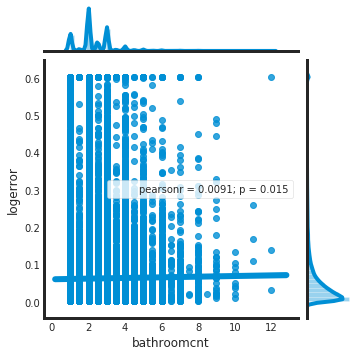

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


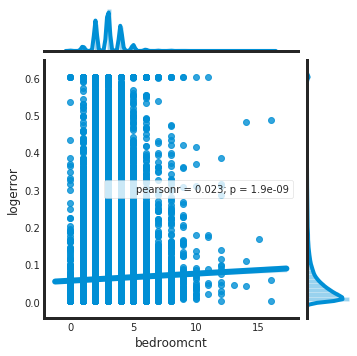

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


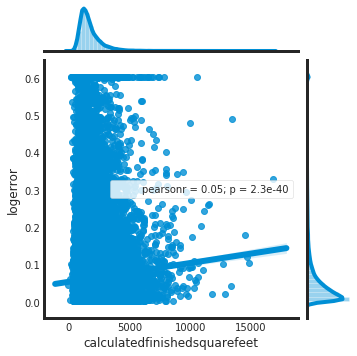

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


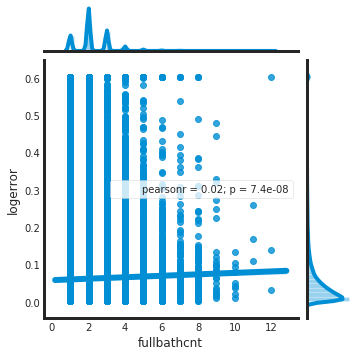

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


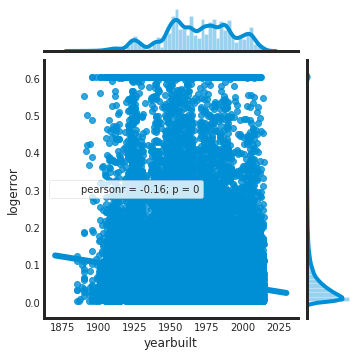

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


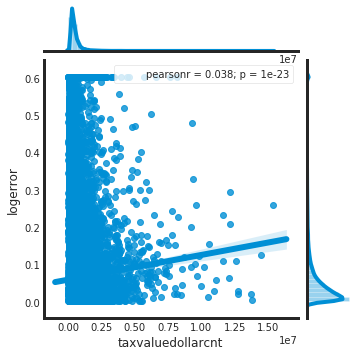

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


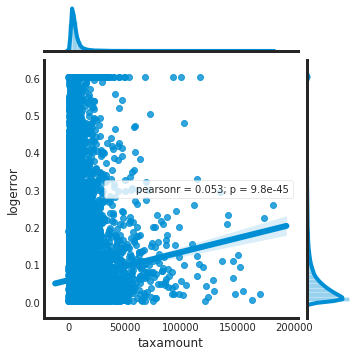

In [26]:
with sns.axes_style('white'):
    j = sns.jointplot('bathroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('bedroomcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('calculatedfinishedsquarefeet', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('fullbathcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('yearbuilt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxvaluedollarcnt', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('taxamount', "logerror", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a jointplot for each independent variable with the dependent variable. 
- normalized version

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


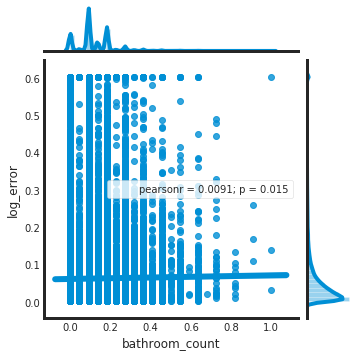

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


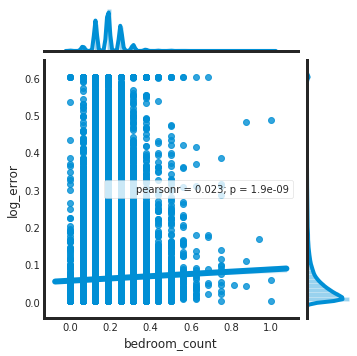

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


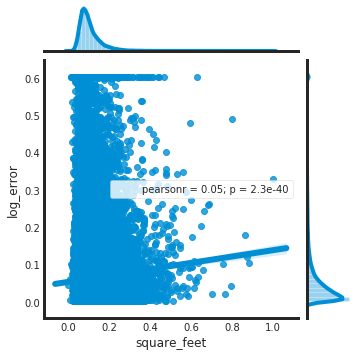

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


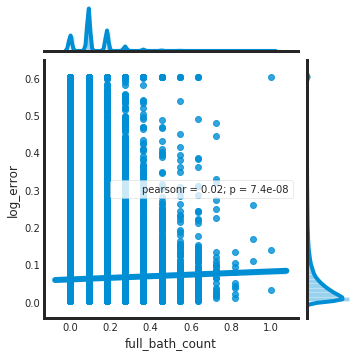

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


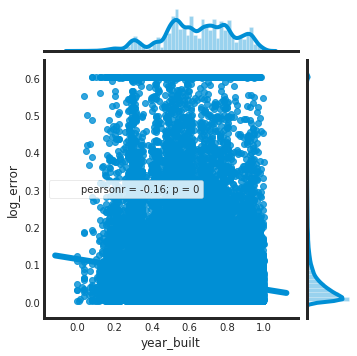

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


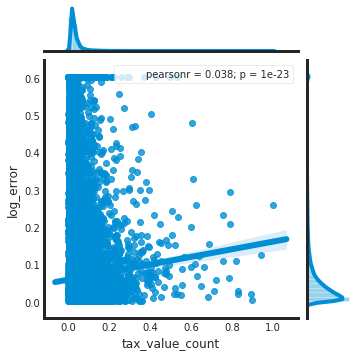

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


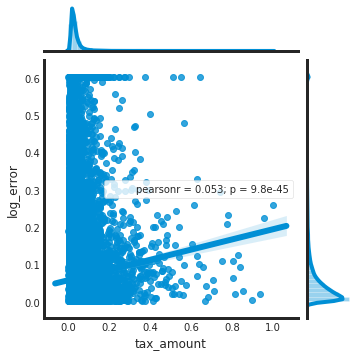

In [27]:
with sns.axes_style('white'):
    j = sns.jointplot('bathroom_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('bedroom_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('square_feet', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('full_bath_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('year_built', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('tax_value_count', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot('tax_amount', "log_error", data=std_train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 
- UNnormalized version

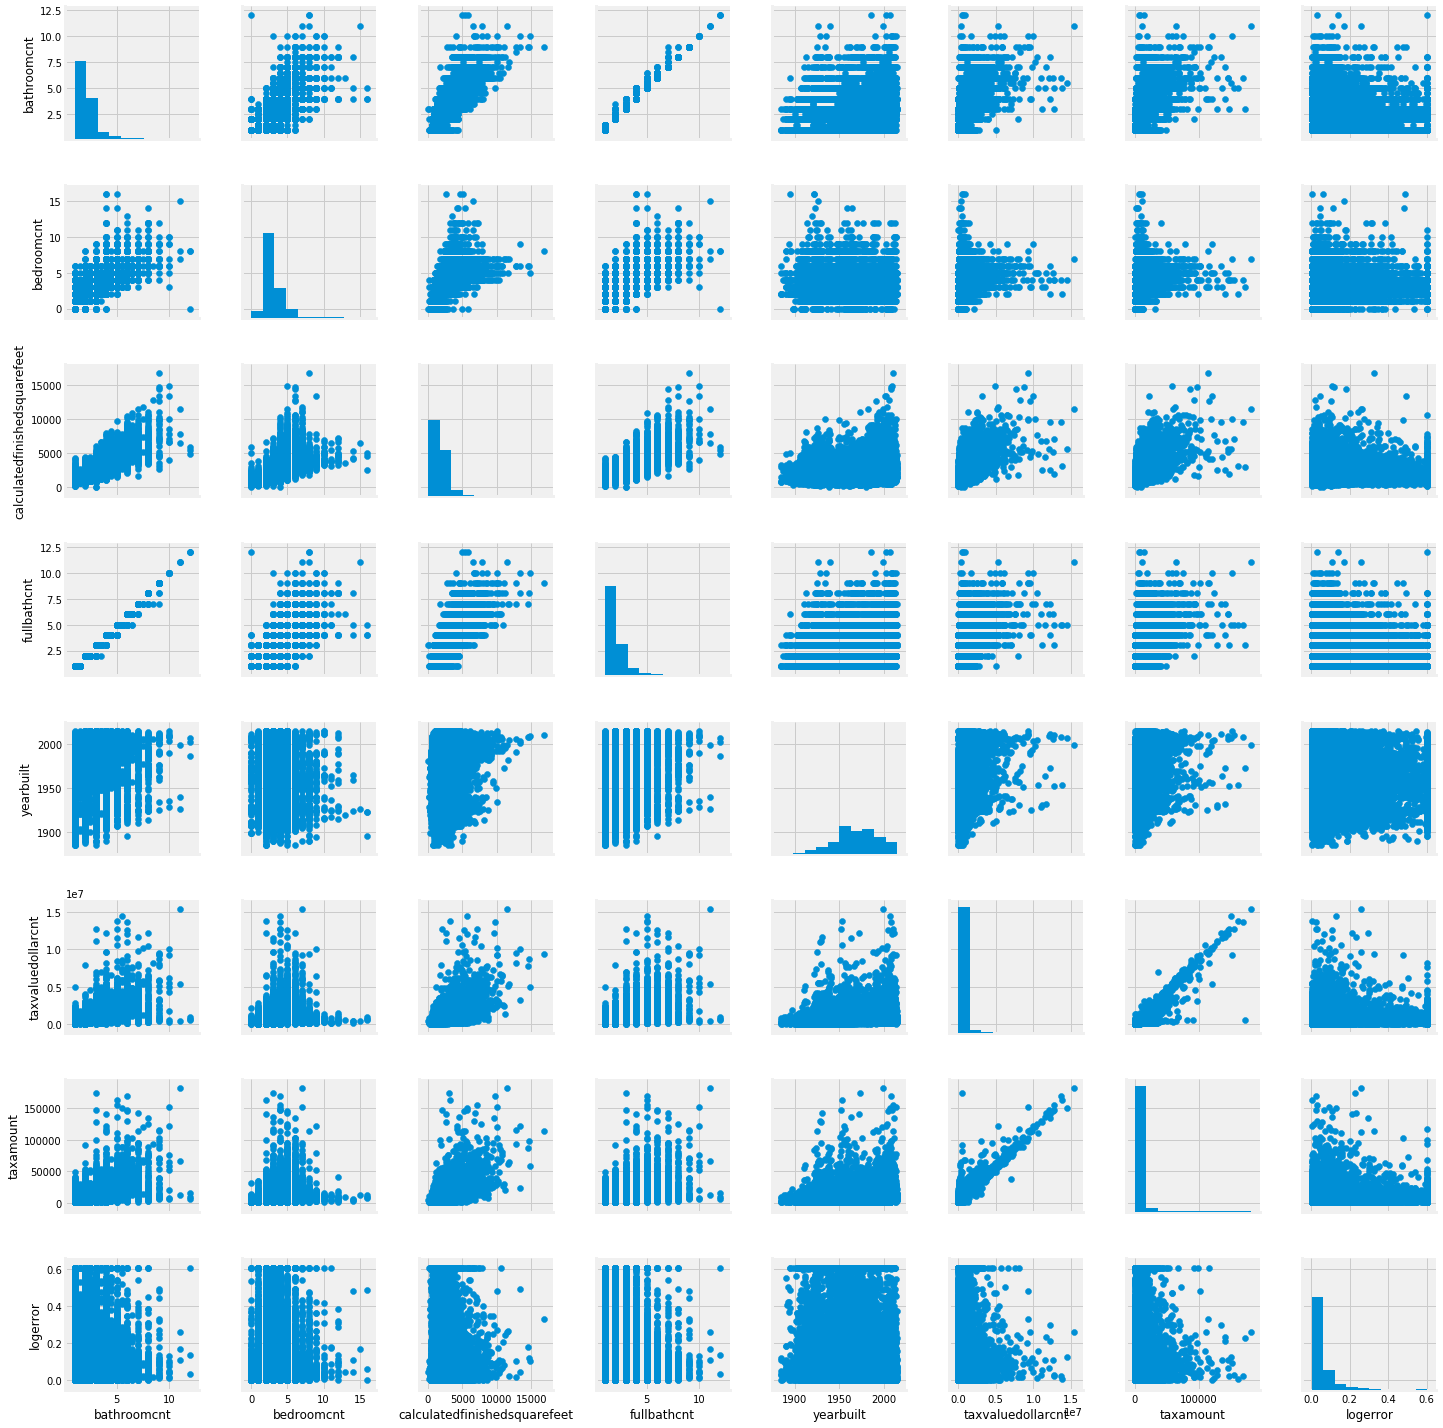

In [28]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 
- normalized version

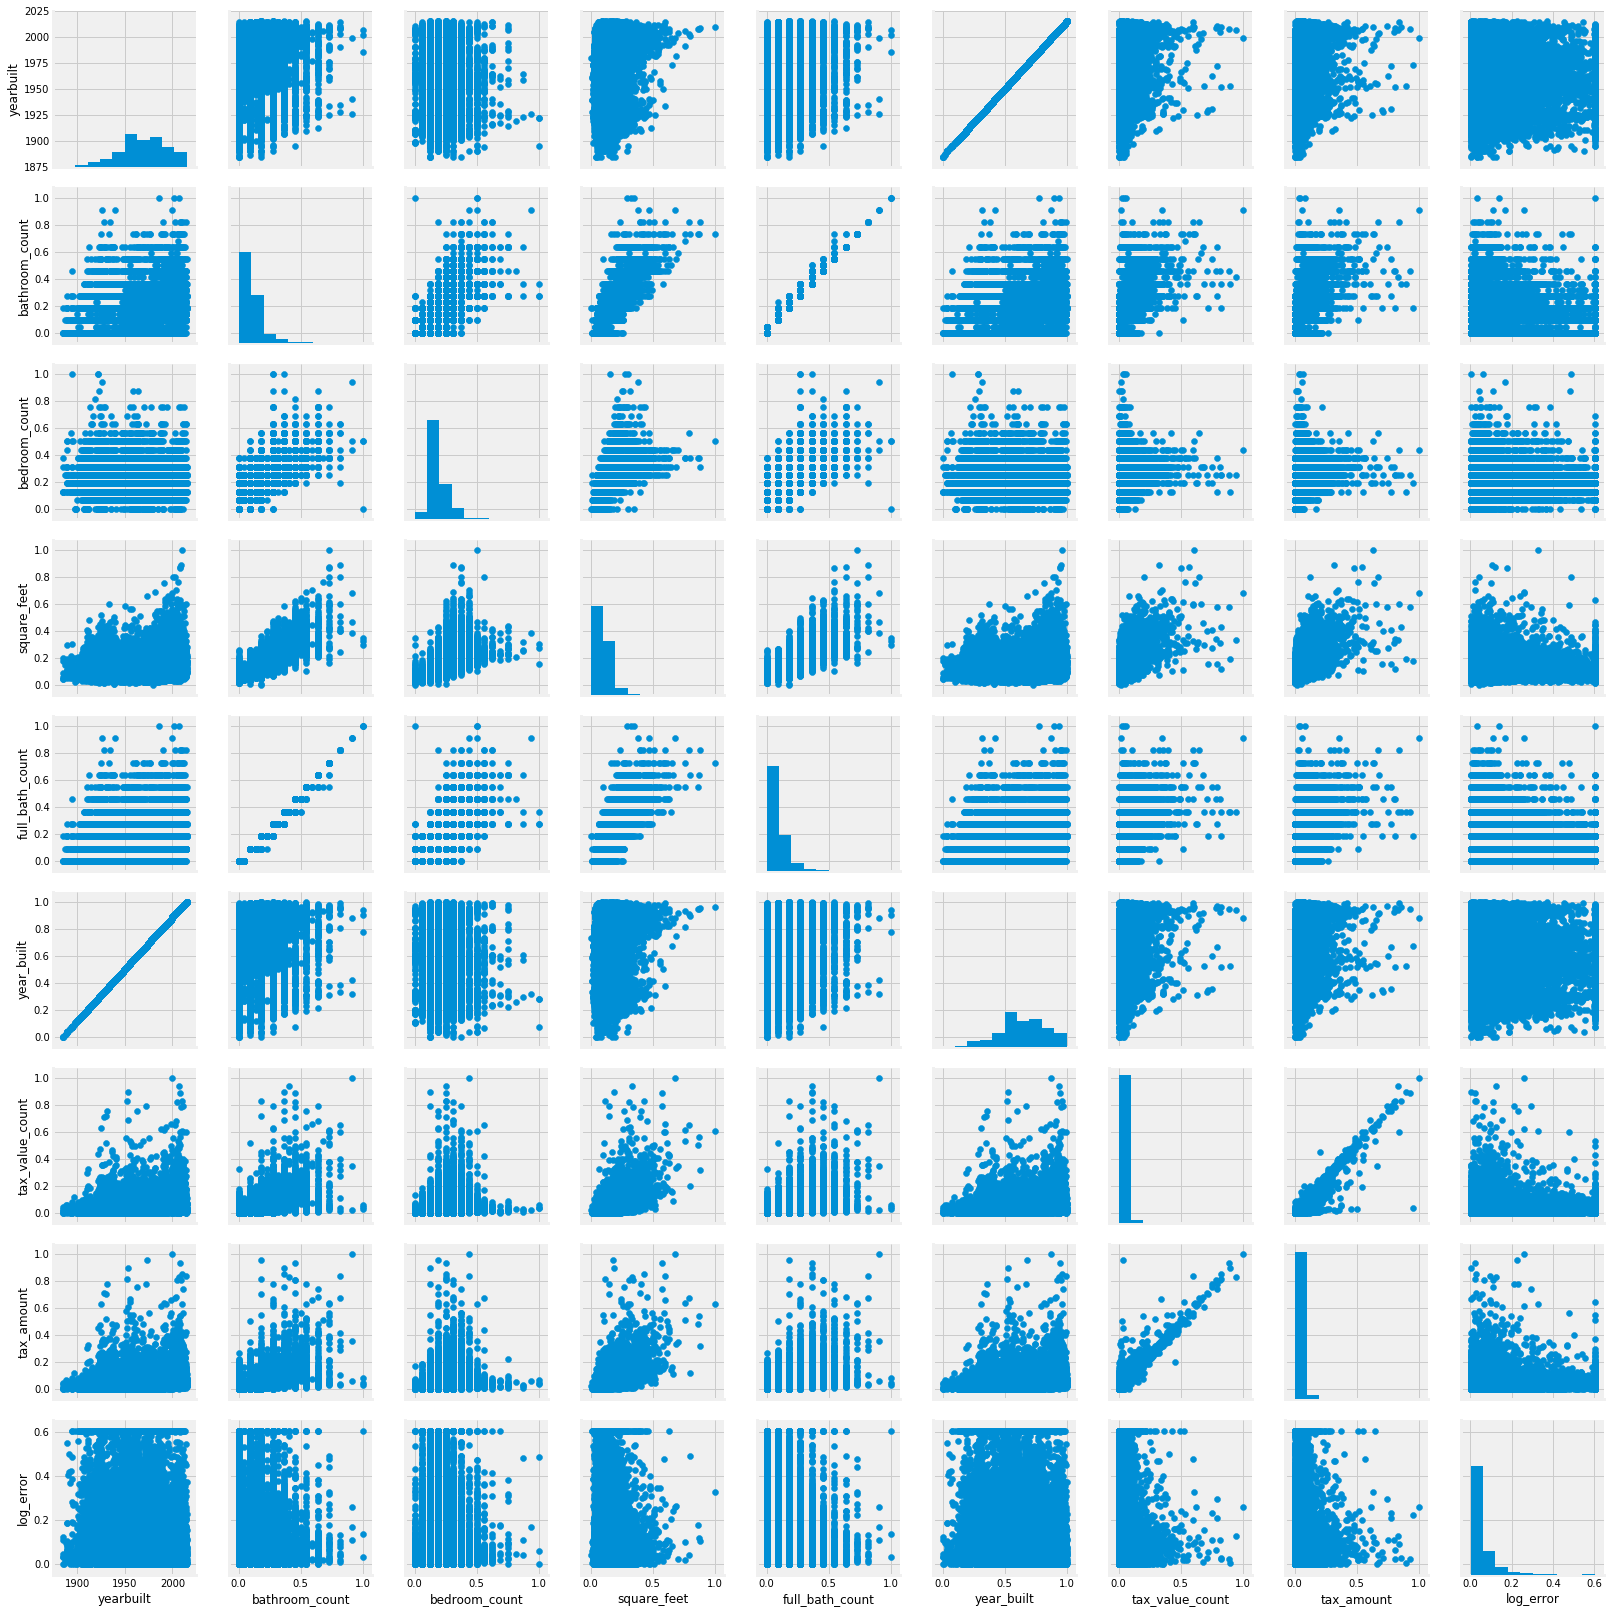

In [29]:
g = sns.PairGrid(std_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#### Create a heatmap of the correlation between each variable pair.
- UNnormalized version

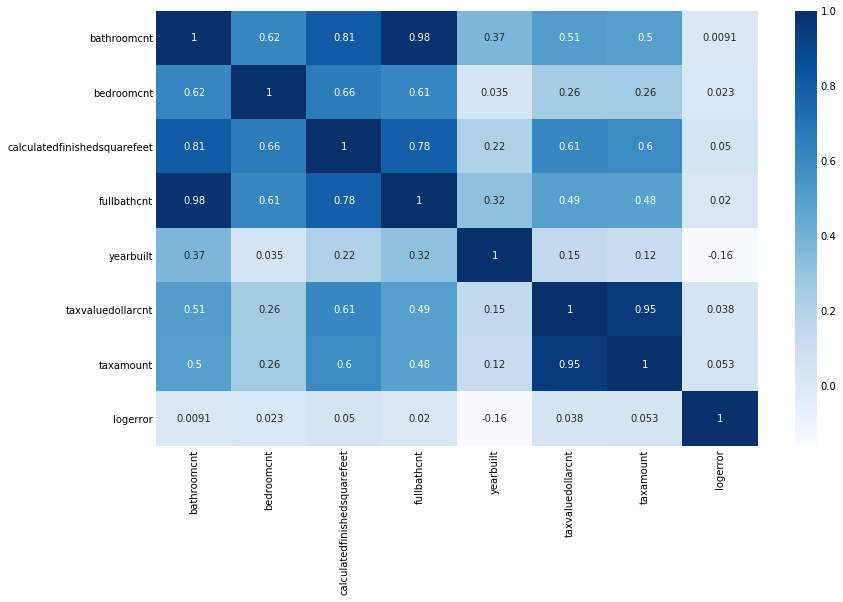

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Create a heatmap of the correlation between each variable pair.
- normalized version

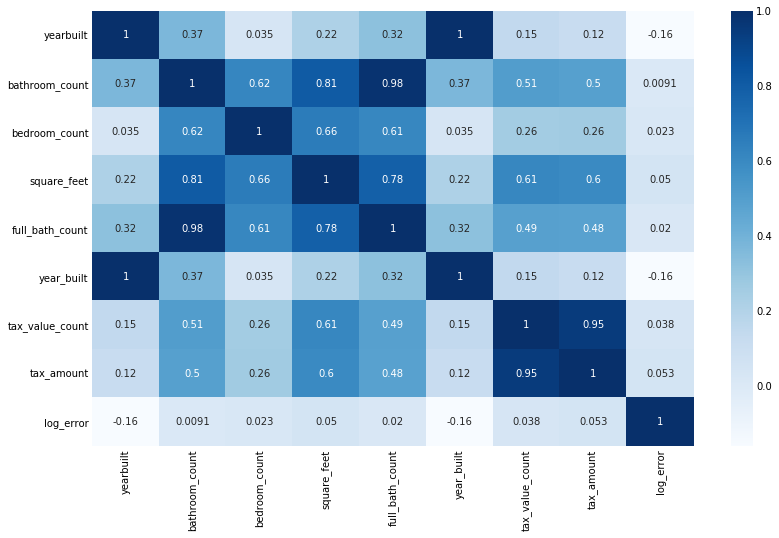

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(std_train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

- At this point, only questions #2, #3, and #5 are the ones that can be addressed.

***Log error is nicely distributed and follows a pretty standard or normal distribution. The biggest driver are 1) taxes and square feet. The number of bathrooms and bedrooms do very little in affecting the log error. Meaning, the current Zestimate model already does a very good job in predicting sale prices based on these variables. In conclusion, the Zestimate model can "Zing" better if tax amount, calculated square feet, and tax-assessed value of the property are further investigated and taken into account some more.***

- Both location and HVAC related fields still need to imported and examined.

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [32]:
data_bed_3 = train[train['bedroomcnt'] == 3.0]
data_bed_5 = train[train['bedroomcnt'] >= 5.0]

stat, p = stats.ttest_ind(data_bed_3['logerror'], data_bed_5['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

# if p-value is < 0.05, you can reject the null hypothesis

T-stat: -14.904199659914447
p-value: 4.469207805697199e-50


#### Do the same for another 2 samples that we are interested in comparing.

In [33]:
data_bath_1 = train[train['bathroomcnt'] == 1.0]
data_bath_2 = train[train['bathroomcnt'] >= 2.0]

stat, p = stats.ttest_ind(data_bath_1['logerror'], data_bath_2['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 19.083488175403506
p-value: 5.571188299610537e-81


In [34]:
data_sq_small = train[train['calculatedfinishedsquarefeet'] < 1300.0]
data_sq_large = train[train['calculatedfinishedsquarefeet'] >= 1300.0]

stat, p = stats.ttest_ind(data_sq_small['logerror'], data_sq_large['logerror'])
print(f'T-stat: {stat}')
print(f'p-value: {p}')

T-stat: 3.5719632323554213
p-value: 0.0003545487680126004


### Data Modeling

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [35]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     4746.
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:43:48   Log-Likelihood:                 68637.
No. Observations:               71192   AIC:                        -1.373e+05
Df Residuals:                   71185   BIC:                        -1.372e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0445      0.002    -21.005      0.000      -0.049      -0.040
bedroomcnt                      -0.0001      0.000     -0.321      0.748      -0.001       0.001
calculatedfinishedsquarefeet  1.205e-05   7.72e-07     15.617      0.000    1.05e-05    1.36e-05
fullbathcnt                      0.0364      0.002     17.752      0.000       0.032       0.040
yearbuilt                     3.031e-05   5.54e-07     54.759      0.000    2.92e-05    3.14e-05
taxvaluedollarcnt            -2.067e-08   2.13e-09     -9.708      0.000   -2.48e-08   -1.65e-08
taxamount                     2.041e-06   1.71e-07     11.966      0.000    1.71e-06    2.37e-06
==============================================================================
Omnibus:                    52099.983   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           791008.785
Skew:                           3.500   Prob(JB):                         0.00
Kurtosis:                      17.753   Cond. No.                     5.87e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Train & Test Model

In [36]:
# Create linear regression objects
lm1 = LinearRegression()
print(lm1)

lm1.fit(X_train[['calculatedfinishedsquarefeet']], y_train)
print(lm1)

lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

print()
print('Univariate - log error = b + m1 * square feet')
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])

y_pred_lm1 = lm1.predict(X_train[['calculatedfinishedsquarefeet']])

mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)

print('  {:.2%} of the variance in the log error can be explained by the number of square feet.'.format(r2_lm1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.05343332]
[[5.05228772e-06]]

Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.05
    coefficient (m1): 0.00
lm1
  mse: 0.00858
  0.25% of the variance in the log error can be explained by the number of square feet.


In [37]:
# Create linear regression objects
lm2 = LinearRegression()
print(lm2)

lm2.fit(X_train[['bathroomcnt', 'fullbathcnt']], y_train)
print(lm2)

lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

print()
print('Multivariate - log error = b + m1 * bathroom count + m2 * full bath count')
print('    y-intercept  (b): %.2f' % lm2_y_intercept)
print('    coefficient (m1): %.2f' % lm2_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm2_coefficients[0][1])

y_pred_lm2 = lm2.predict(X_train[['bathroomcnt', 'fullbathcnt']])

mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm2\n  mse: {:.3}".format(mse_lm2)) 

r2_lm2 = r2_score(y_train, y_pred_lm2)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm2))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.0603551]
[[-0.03224535  0.03411209]]

Multivariate - log error = b + m1 * bathroom count + m2 * full bath count
    y-intercept  (b): 0.06
    coefficient (m1): -0.03
    coefficient (m2): 0.03
lm2
  mse: 0.00856
  0.40% of the variance in the log error can be explained by the number of bathrooms.


In [38]:
# Create linear regression objects
lm3 = LinearRegression()
print(lm3)

lm3.fit(X_train[['bedroomcnt']], y_train)
print(lm3)

lm3_y_intercept = lm3.intercept_
print(lm3_y_intercept)

lm3_coefficients = lm3.coef_
print(lm3_coefficients)

print()
print('Multivariate - log error = b + m1 * bedroom count')
print('    y-intercept  (b): %.2f' % lm3_y_intercept)
print('    coefficient (m1): %.2f' % lm3_coefficients[0][0])

y_pred_lm3 = lm3.predict(X_train[['bedroomcnt']])

mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
print("lm3\n  mse: {:.3}".format(mse_lm3)) 

r2_lm3 = r2_score(y_train, y_pred_lm3)

print('  {:.2%} of the variance in the log error can be explained by the number of bedrooms.'.format(r2_lm3))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.0565702]
[[0.00188704]]

Multivariate - log error = b + m1 * bedroom count
    y-intercept  (b): 0.06
    coefficient (m1): 0.00
lm3
  mse: 0.00859
  0.05% of the variance in the log error can be explained by the number of bedrooms.


In [39]:
# Create linear regression objects
lm4 = LinearRegression()
print(lm4)

lm4.fit(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']], y_train)
print(lm4)

lm4_y_intercept = lm4.intercept_
print(lm4_y_intercept)

lm4_coefficients = lm4.coef_
print(lm4_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm4_y_intercept)
print('    coefficient (m1): %.2f' % lm4_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm4_coefficients[0][2])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][3])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][4])
print('    coefficient (m2): %.2f' % lm4_coefficients[0][5])

y_pred_lm4 = lm4.predict(X_train[['calculatedfinishedsquarefeet', 'bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'taxamount']])

mse_lm4 = mean_squared_error(y_train, y_pred_lm4)
print("lm4\n  mse: {:.3}".format(mse_lm4)) 

r2_lm4 = r2_score(y_train, y_pred_lm4)

print('  {:.2%} of the variance in the log error can be explained by the number of bathrooms.'.format(r2_lm4))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.06086611]
[[ 1.21828806e-05 -4.34674090e-02  3.55780204e-02 -6.77159732e-04
  -2.03815311e-08  2.00676322e-06]]

Multivariate:
    y-intercept  (b): 0.06
    coefficient (m1): 0.00
    coefficient (m2): -0.04
    coefficient (m1): 0.04
    coefficient (m2): -0.00
    coefficient (m2): -0.00
    coefficient (m2): 0.00
lm4
  mse: 0.00849
  1.21% of the variance in the log error can be explained by the number of bathrooms.


In [40]:
# Create linear regression objects
lm5 = LinearRegression()
print(lm5)

lm5.fit(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']], y_train)
print(lm5)

lm5_y_intercept = lm5.intercept_
print(lm5_y_intercept)

lm5_coefficients = lm5.coef_
print(lm5_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm5_y_intercept)
print('    coefficient (m1): %.2f' % lm5_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm5_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm5_coefficients[0][2])

y_pred_lm5 = lm5.predict(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])

mse_lm5 = mean_squared_error(y_train, y_pred_lm5)
print("lm5\n  mse: {:.3}".format(mse_lm5)) 

r2_lm5 = r2_score(y_train, y_pred_lm5)

print('  {:.2%} of the variance in the log error can be explained by tax and square feet.'.format(r2_lm5))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[0.05298137]
[[ 3.80536996e-06 -2.43677182e-08  2.31040195e-06]]

Multivariate:
    y-intercept  (b): 0.05
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m1): 0.00
lm5
  mse: 0.00855
  0.51% of the variance in the log error can be explained by tax and square feet.


In [41]:
# Create linear regression objects
lm6 = LinearRegression()
print(lm6)

lm6.fit(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']], y_train)
print(lm6)

lm6_y_intercept = lm6.intercept_
print(lm6_y_intercept)

lm6_coefficients = lm6.coef_
print(lm6_coefficients)

print()
print('Multivariate:')
print('    y-intercept  (b): %.2f' % lm6_y_intercept)
print('    coefficient (m1): %.2f' % lm6_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm6_coefficients[0][1])
print('    coefficient (m1): %.2f' % lm6_coefficients[0][2])
print('    coefficient (m1): %.2f' % lm6_coefficients[0][3])

y_pred_lm6 = lm6.predict(X_train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']])

mse_lm6 = mean_squared_error(y_train, y_pred_lm6)
print("lm6\n  mse: {:.3}".format(mse_lm6)) 

r2_lm6 = r2_score(y_train, y_pred_lm6)

print('  {:.2%} of the variance in the log error can be explained by tax, square feet, and year built.'.format(r2_lm6))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[1.40339011]
[[ 7.57043555e-06 -1.67797787e-08  1.71039269e-06 -6.89318921e-04]]

Multivariate:
    y-intercept  (b): 1.40
    coefficient (m1): 0.00
    coefficient (m2): -0.00
    coefficient (m1): 0.00
    coefficient (m1): -0.00
lm6
  mse: 0.0083
  3.48% of the variance in the log error can be explained by tax, square feet, and year built.


#### Model #6 yields the best results of all training models.

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

Text(0.5, 1.0, 'Predicted vs Actual Log Error')

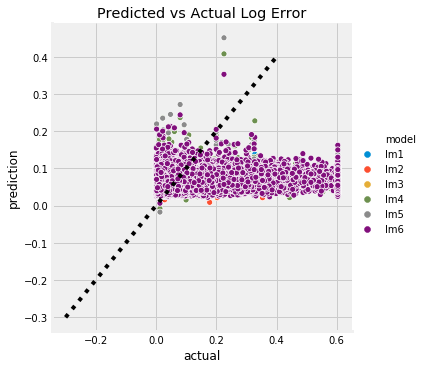

In [42]:
# We want just a single array of predictions. We can use
# the .ravel method to achieve this.

pd.DataFrame({'actual': y_train.logerror,
              'lm1': y_pred_lm1.ravel(),
              'lm2': y_pred_lm2.ravel(),
              'lm3': y_pred_lm3.ravel(),
              'lm4': y_pred_lm4.ravel(),
              'lm5': y_pred_lm5.ravel(),
              'lm6': y_pred_lm6.ravel()
             })\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.plot([-.3, .4], [-.3, .4], c='black', ls=':')
plt.title('Predicted vs Actual Log Error')

#### Predict log errors using testing data

In [43]:
# Make predictions using the testing set
y_pred_lm6 = lm6.predict(X_test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount', 'yearbuilt']])

#### Evaluate performance

In [45]:
mse = mean_squared_error(y_test, y_pred_lm6)

print("Mean squared error: %.2f" % mse)

Mean squared error: 0.01


In [46]:
r2 = r2_score(y_test, y_pred_lm6)

print('{:.2%} of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.'
      .format(r2))

4.02% of the variance in log errors can be explained by calculatedfinishedsquarefeet, bathroomcnt, fullbathcnt, bedroomcnt, taxvaluedollarcnt, taxamount.


Text(0, 0.5, 'Residuals')

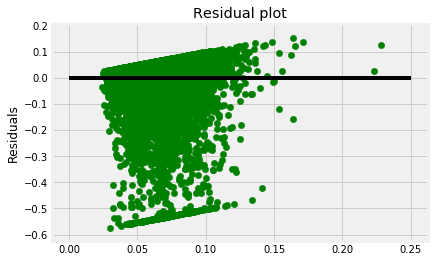

In [47]:
plt.scatter(y_pred_lm6, y_pred_lm6 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=.25)
plt.title("Residual plot")
plt.ylabel('Residuals')